# 1. Load modules

In [1]:
#%matplotlib widget 
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker
from scipy import optimize
import os, sys
from pathlib import Path
import xrdpy

# 2. Set up the xrd-file path

In [2]:
xrdpy_test_path = Path().absolute()

In [3]:
filepath = os.path.join(xrdpy_test_path,"xrd_files")
filename1 = "NT3330_RSM_w2T-2T-105AlN-AlGaN.xrdml"
#filename2 = "NT3334C_RSM_w2T-2T-105AlN-AlGaN_fast.xrdml"
filename2 = 'NT3285_RSM_w-2T_105AlGaN_calibration_fine.xrdml'

In [4]:
savefig = True
save_fig_path = os.path.join(xrdpy_test_path,"../imgs")

In [5]:
gen_fns = xrdpy.general_fns(print_log='low')
xrd_ = xrdpy.xrd(print_log='low')
xrd_plt = xrdpy.plottings(save_figure_dir=save_fig_path, print_log='low')

# 3. Set default variables

#### Variable source: https://www.ioffe.ru/SVA/NSM/Semicond/

In [6]:
alloy_type='ternary' 
structure_type='wz'

# Lattice parameters for AlN and GaN binaries
AlN_a, AlN_c = 3.112, 4.982
GaN_a, GaN_c = 3.189, 5.185    

# Cij parameters for AlN and GaN binaries
GaN_C13 = 106
GaN_C33 = 398
AlN_C13 = 108
AlN_C33 = 373

# Bowing parameters
bowing_a = 0.0
bowing_c = 0.0
bowing_C13 = 0.0
bowing_C33 = 0.0

# reciprocal axes are multiplited by this number to make enlarge axes
mul_fact = 10000

# a_lp_bin: [a_lattice_parameter bin_1, a_lattice_parameter bin_2, bowing]
# For ternary_wz we need followings: [a_lp_bin, c_lp_bin, c13_bin, c33_bin]
list_binary_parameters = [[AlN_a, GaN_a, bowing_a], [AlN_c, GaN_c, bowing_c],
                          [AlN_C13, GaN_C13, bowing_C13], [AlN_C33, GaN_C33, bowing_C33]]

# Reflection plane hkl
hkl = (1,0,5)

# 4. Read xrd-file

## 4.1 Real space data

__Note__: __'1'__ is for data from filename1 and __'2'__ appending is for filename2 data

In [7]:
lambda_wavelength1, two_theta_values1, omega_values1, rsm_intesity1  = \
    xrd_.xrd_read_data(xrd_file_name=os.path.join(filepath, filename1))
#==========================================================================================
lambda_wavelength2, two_theta_values2, omega_values2, rsm_intesity2  = \
    xrd_.xrd_read_data(xrd_file_name=os.path.join(filepath, filename2))
#==========================================================================================
# X-ray wave number
R1 = 1/lambda_wavelength1
R2 = 1/lambda_wavelength2

Wavelength used: 1.5405980
Wavelength used: 1.5405980


## 4.2 Reciprocal space conversion

In [8]:
total_two_theta_in_row1 = np.shape(rsm_intesity1)[1]
rec_space_x1, rec_space_y1 = xrd_.Qxy(omega=omega_values1, two_theta=two_theta_values1,
                                      total_two_theta_in_row=total_two_theta_in_row1,
                                      R=R1, mul_fact=mul_fact)
#==========================================================================================
total_two_theta_in_row2 = np.shape(rsm_intesity2)[1]
rec_space_x2, rec_space_y2 = xrd_.Qxy(omega=omega_values2, two_theta=two_theta_values2,
                                      total_two_theta_in_row=total_two_theta_in_row2,
                                      R=R2, mul_fact=mul_fact)

# 5. Perform post-calculations from maps

## 5.1 Find peaks before shift

In [9]:
_, peaks_x1, peaks_y1, peaks_z1 = xrd_.find_peaks(rec_space_x1, rec_space_y1, rsm_intesity1, 
                                                                 apply_filter=True, threshold=100, 
                                                                 sigma=1, filter_type='gaussian')
#==========================================================================================
_, peaks_x2, peaks_y2, peaks_z2 = xrd_.find_peaks(rec_space_x2, rec_space_y2, rsm_intesity2, 
                                                                 apply_filter=True, threshold=100, 
                                                                 sigma=1, filter_type='gaussian')

In [10]:
print('- Graph 1')
print(f'-- Peaks x-coord: {peaks_x1}\n--Peaks y-coord: {peaks_y1}\n--Peaks intensities: {peaks_z1}')
#==========================================================================================
print('- Graph 2')
print(f'--Peaks x-coord: {peaks_x2}\n--Peaks y-coord: {peaks_y2}\n--Peaks intensities: {peaks_z2}')

- Graph 1
-- Peaks x-coord: [3683.51567323 3695.72206197]
--Peaks y-coord: [ 9961.90564548 10040.15579773]
--Peaks intensities: [3691.  798.]
- Graph 2
--Peaks x-coord: [3770.7147201  3772.78904992 3773.61709504 3774.66367725 3775.9373537
 3775.33155708 3776.83144145 3776.74373393]
--Peaks y-coord: [ 9850.99308842  9897.30672175  9914.89420765  9946.0223383
  9957.14520591  9973.7086386  10006.33838239 10019.18401303]
--Peaks intensities: [1529. 1568. 1639. 1383. 1403. 1331.  268. 2633.]


## 5.2 Plot before shift

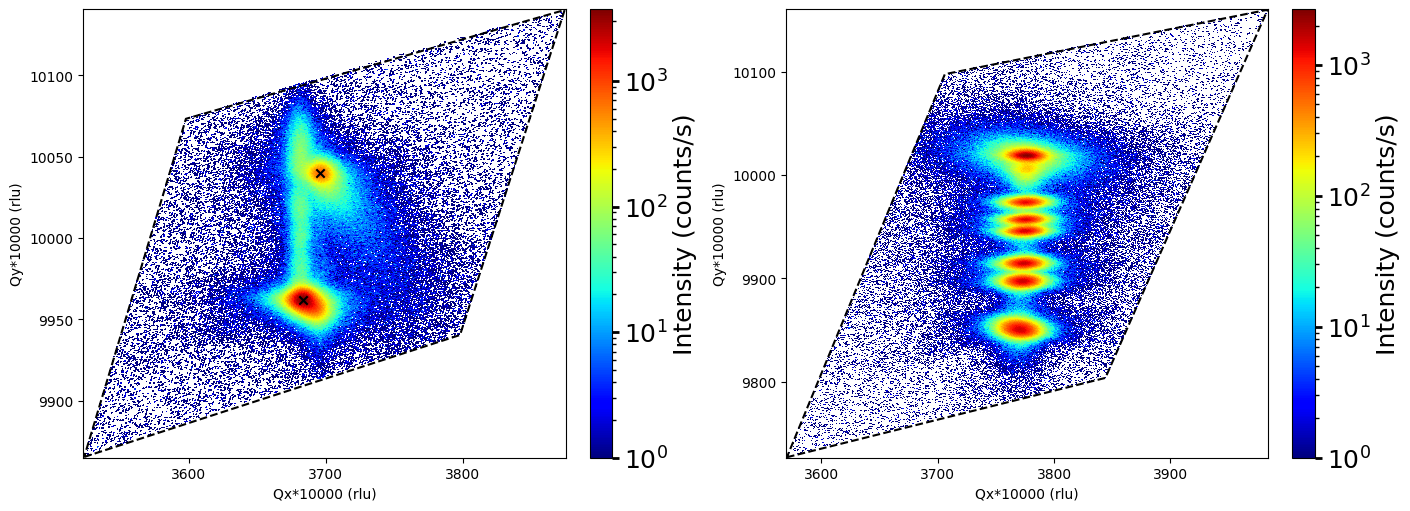

In [11]:
xlabel_text = f'Qx*{mul_fact} (rlu)'
ylabel_text = f'Qy*{mul_fact} (rlu)'
save_file_name = None

fig, axs = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[0], show_plot=False,
                              save_file_name=None, x_values=rec_space_x1, 
                              y_values=rec_space_y1, z_values=rsm_intesity1,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')
axs[0].scatter(peaks_x1, peaks_y1, marker='x', color='k')
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[1], 
                              save_file_name=None, x_values=rec_space_x2, 
                              y_values=rec_space_y2, z_values=rsm_intesity2,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')
axs[1].scatter(peaks_x2, peaks_y2, marker='x', color='k')

## 5.3 Estimate the compostion and strain relaxation of other peaks in reciprocal space map
Note: In this tutoral we want to find the positions of lowest peaks

In [12]:
find_results_4_peak1 = [peaks_x1[0], peaks_y1[0]]
find_results_4_peak2 = [peaks_x2[0], peaks_y2[0]]

### 5.3.1 Calculate reference point theoretically

In [13]:
# Calculating only for AlN as this is my reference point
rec_space_theor_ref_xy = xrd_.Qxy_theor(AlN_a, AlN_c, hkl=hkl, structure_type=structure_type) 
print(f'Theoretically calculated reference points: {rec_space_theor_ref_xy}')

Theoretically calculated reference points: (3710.477308416618, 10036.130068245684)


### 5.3.2 Get or define the reference point in data
##### E.g. Here we use the highest maximum point as reference (AlN). This will be used as full strain line reference. You use the above figure to decide which point to use as reference.

In [14]:
x_coord_max1 = peaks_x1[-1] 
y_coord_max1 = peaks_y1[-1] 
print(f'-Graph-1 reference experimental peak/point (before shift): {x_coord_max1}, {y_coord_max1}')
#==========================================================================================
x_coord_max2 = peaks_x2[-1]
y_coord_max2 = peaks_y2[-1] 
print(f'-Graph-2 reference experimental peak/point (before shift): {x_coord_max2}, {y_coord_max2}')

-Graph-1 reference experimental peak/point (before shift): 3695.7220619707455, 10040.15579772535
-Graph-2 reference experimental peak/point (before shift): 3776.7437339265052, 10019.184013026219


### 5.3.3 Calculate shift required to map experimental referernce on theoretically calculated reference

In [15]:
# Calcuate shift amount
shift_xy_1 = np.array([rec_space_theor_ref_xy[0]-x_coord_max1, rec_space_theor_ref_xy[1]-y_coord_max1])
print(f'-Graph-1 shift of refence peak: {shift_xy_1}')
#==========================================================================================
# Calcuate shift amount
shift_xy_2 = np.array([rec_space_theor_ref_xy[0]-x_coord_max2, rec_space_theor_ref_xy[1]-y_coord_max2])
print(f'-Graph-2 shift of refence peak: {shift_xy_2}')

-Graph-1 shift of refence peak: [14.75524645 -4.02572948]
-Graph-2 shift of refence peak: [-66.26642551  16.94605522]


### 5.3.4 Shift experimental data

In [16]:
rec_space_x_shift1 = rec_space_x1 + shift_xy_1[0]  # Shifting x-coordinates
rec_space_y_shift1 = rec_space_y1 + shift_xy_1[1]  #shifting y-coordinates
# Add the shift to find_results_for_peak in experimental data
find_results_4_peak_shift1 = [find_results_4_peak1[i] + shift_xy_1[i] for i in range(2)]
# Add the shift to reference peak in experimental data
reference_peak1 = [x_coord_max1+shift_xy_1[0], y_coord_max1+shift_xy_1[1]]
print(f'-Graph-1 reference experimental peak/point (after shift): {reference_peak1}')
print(f'-Graph-1 determine results for experimental peak/point (after shift): {find_results_4_peak_shift1}')
print()
#==========================================================================================
rec_space_x_shift2 = rec_space_x2 + shift_xy_2[0]  # Shifting x-coordinates
rec_space_y_shift2 = rec_space_y2 + shift_xy_2[1]  #shifting y-coordinates
# Add the shift to find_results_for_peak in experimental data
find_results_4_peak_shift2 = [find_results_4_peak2[i] + shift_xy_2[i] for i in range(2)]
# Add the shift to reference peak in experimental data
reference_peak2 = [x_coord_max2+shift_xy_2[0], y_coord_max2+shift_xy_2[1]]
print(f'-Graph-2 reference experimental peak/point (after shift): {reference_peak2}')
print(f'-Graph-2 determine results for experimental peak/point (after shift): {find_results_4_peak_shift2}')

-Graph-1 reference experimental peak/point (after shift): [3710.477308416618, 10036.130068245684]
-Graph-1 determine results for experimental peak/point (after shift): [3698.270919675508, 9957.879916004034]

-Graph-2 reference experimental peak/point (after shift): [3710.477308416618, 10036.130068245684]
-Graph-2 determine results for experimental peak/point (after shift): [3704.4482945901755, 9867.939143640133]


### 5.3.5 Calculate composition and relxation for the other peak

In [17]:
optimize_f_args = (list_binary_parameters, mul_fact, alloy_type, structure_type, hkl)

print('- Graph-1 results')
sol1, relaxation1 = xrd_.find_composition_strain_4_point(find_results_4_peak_shift1, reference_peak1,
                                                         optimize_f_args, comp_interval=[0, 1], 
                                                         root_finding_method='brentq')
print('- Graph-2 results')
sol2, relaxation2 = xrd_.find_composition_strain_4_point(find_results_4_peak_shift2, reference_peak2,
                                                         optimize_f_args, comp_interval=[0, 1],
                                                         root_finding_method='brentq')

- Graph-1 results
Solution for requested peak/point: [3698.270919675508, 9957.879916004034]
	-Composition (%)         : 82.25
	-Strain-relaxation (%)   : 0.75
- Graph-2 results
Solution for requested peak/point: [3704.4482945901755, 9867.939143640133]
	-Composition (%)         : 67.19
	-Strain-relaxation (%)   : 0.20


## 5.4 Calculate no-relaxation line (theoretically calulated + shifted to reference point)
#### Note: This sub-subsection is for visualization 

### 5.4.1 Calculate alloy parameter from binary

In [18]:
comps_ = np.linspace(0.5,1,11) #np.arange(0, 1.0+1e-10, step=0.25) 
AlGaN_a, AlGaN_c, AlGaN_C13, AlGaN_C33, AlGaN_D = \
    gen_fns.alloy_parameters_from_binary(comps_, list_binary_parameters, 
                                         alloy_type=alloy_type, structure_type=structure_type)

### 5.4.2 Completely relaxaed (no-strain) line

In [19]:
rec_space_theor_AlGaN = xrd_.Qxy_theor(AlGaN_a, AlGaN_c, hkl=hkl, structure_type=structure_type)

## 5.5 Find peaks after shift

In [20]:
_, peaks_x_shift1, peaks_y_shift1, peaks_z_shift1 = xrd_.find_peaks(rec_space_x_shift1, rec_space_y_shift1, rsm_intesity1, 
                                                                    apply_filter=True, threshold=100,
                                                                    sigma=1, filter_type='gaussian')
#==========================================================================================
_, peaks_x_shift2, peaks_y_shift2, peaks_z_shift2 = xrd_.find_peaks(rec_space_x_shift2, rec_space_y_shift2, rsm_intesity2, 
                                                                    apply_filter=True, threshold=100, 
                                                                    sigma=1, filter_type='gaussian')

In [21]:
print('- Graph-1')
print(f'--Peaks x-coord: {peaks_x_shift1}\n--Peaks y-coord: {peaks_y_shift1}\n--Peaks intensities: {peaks_z_shift1}')
#==========================================================================================
print('- Graph-2')
print(f'--Peaks x-coord: {peaks_x_shift2}\n--Peaks y-coord: {peaks_y_shift2}\n--Peaks intensities: {peaks_z2}')

- Graph-1
--Peaks x-coord: [3698.27091968 3710.47730842]
--Peaks y-coord: [ 9957.879916   10036.13006825]
--Peaks intensities: [3691.  798.]
- Graph-2
--Peaks x-coord: [3704.44829459 3706.52262441 3707.35066953 3708.39725174 3709.67092819
 3709.06513157 3710.56501594 3710.47730842]
--Peaks y-coord: [ 9867.93914364  9914.25277697  9931.84026287  9962.96839352
  9974.09126113  9990.65469382 10023.28443761 10036.13006825]
--Peaks intensities: [1529. 1568. 1639. 1383. 1403. 1331.  268. 2633.]


# 6. Plot reciprocal space maps

## 6.1 Plot them just side by side

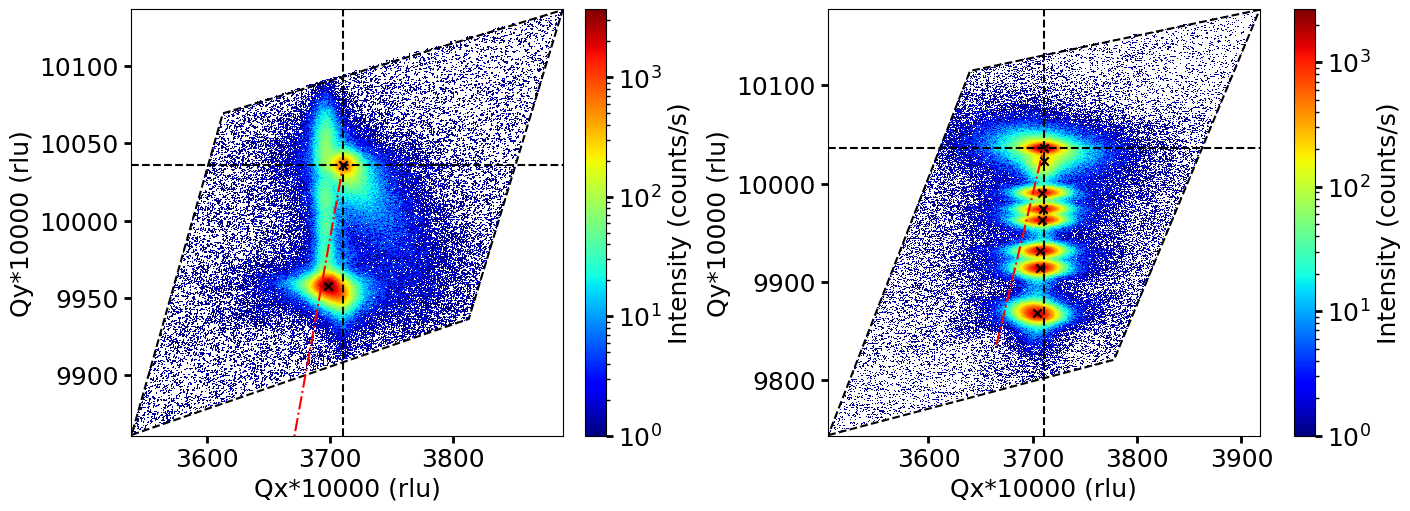

In [22]:
xlabel_text = f'Qx*{mul_fact} (rlu)'
ylabel_text = f'Qy*{mul_fact} (rlu)'
save_file_name = None

fig, axs = plt.subplots(1, 2, figsize=(14,5), constrained_layout=True)
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[0], show_plot=False,
                              save_file_name=None, x_values=rec_space_x_shift1, 
                              y_values=rec_space_y_shift1, z_values=rsm_intesity1,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)')

# #==================== add no-strain lines (red dash) ==================
axs[0].plot(rec_space_theor_AlGaN[0], rec_space_theor_AlGaN[1], color='r', ls='-.')

#==================== add reference lines (black dash) ================
axs[0].axhline(y=reference_peak1[1], ls='--', color='black')
axs[0].axvline(x=reference_peak1[0], ls='--', color='black')

#=============================== plot peaks ===========================
axs[0].scatter(peaks_x_shift1, peaks_y_shift1, marker='x', color='k')

#****************************************************************************************************
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[1], 
                              save_file_name=None, x_values=rec_space_x_shift2, 
                              y_values=rec_space_y_shift2, z_values=rsm_intesity2,
                              mode="reciprocal_space", xaxis_label=xlabel_text,
                              yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                              colorbar_label='Intensity (counts/s)', show_plot=False)
# #==================== add no-strain lines (red dash) ==================
axs[1].plot(rec_space_theor_AlGaN[0], rec_space_theor_AlGaN[1], color='r', ls='-.')

#==================== add reference lines (black dash) ================
axs[1].axhline(y=reference_peak2[1], ls='--', color='black')
axs[1].axvline(x=reference_peak2[0], ls='--', color='black')

#=============================== plot peaks ===========================
axs[1].scatter(peaks_x_shift2, peaks_y_shift2, marker='x', color='k')

#plt.close()

## 6.2 Plot them just side by side but remove 2nd y-axis

In [23]:
xlabel_text = f'Qx*{mul_fact} (rlu)'
ylabel_text = f'Qy*{mul_fact} (rlu)'
save_file_name = 'AlN_AlGaN_AlN_reciprocal_space_overlay.png' if savefig else None

vmin, vmax = 1, max(rsm_intesity1.max(), rsm_intesity2.max()) # vmin can not be exatly 0.
threshold_intensity_ = 2

xmin, xmax = min(rec_space_x_shift1.min(), rec_space_x_shift2.min()), max(rec_space_x_shift1.max(), rec_space_x_shift2.max())
ymin, ymax = min(rec_space_y_shift1.min(), rec_space_y_shift2.min()), max(rec_space_y_shift1.max(), rec_space_y_shift2.max())

fig, axs = plt.subplots(1, 2, figsize=(12,5), constrained_layout=True)

#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[0], show_plot=False,
                             Ymin=ymin, Ymax=ymax, Xmin=xmin, Xmax=xmax,
                             save_file_name=None, x_values=rec_space_x_shift1, 
                             y_values=rec_space_y_shift1, z_values=rsm_intesity1,
                             mode="reciprocal_space", xaxis_label=xlabel_text,
                             vmin=vmin, vmax=vmax, threshold_intensity=threshold_intensity_,
                             yaxis_label=ylabel_text, color_map='jet', color_scale='log',
                             colorbar_label='Intensity (counts/s)', show_colorbar=False)
axs[1].yaxis.set_visible(False)
# #==================== add no-strain lines (red dash) ==================
axs[0].plot(rec_space_theor_AlGaN[0], rec_space_theor_AlGaN[1], color='r', ls='-.')

#==================== add reference lines (black dash) ================
axs[0].axhline(y=reference_peak1[1], ls='--', color='black')
axs[0].axvline(x=reference_peak1[0], ls='--', color='black')

#=============================== plot peaks ===========================
axs[0].scatter(peaks_x_shift1, peaks_y_shift1, marker='x', color='k')

#******************************************************************************************************
#====================== Plot the map =================================
fig, _, _ = xrd_plt.xrd_plot(fig=fig, ax=axs[1], Ymin=ymin, Ymax=ymax,
                             Xmin=xmin, Xmax=xmax, vmin=vmin, vmax=vmax,
                             x_values=rec_space_x_shift2, show_plot=False,
                             y_values=rec_space_y_shift2, z_values=rsm_intesity2,
                             mode="reciprocal_space", xaxis_label=xlabel_text,
                             threshold_intensity=threshold_intensity_,
                             yaxis_label='', color_map='jet', color_scale='log',
                             colorbar_label='Intensity (counts/s)')
# #==================== add no-strain lines (red dash) ==================
axs[1].plot(rec_space_theor_AlGaN[0], rec_space_theor_AlGaN[1], color='r', ls='-.')

#==================== add reference lines (black dash) ================
axs[1].axhline(y=reference_peak2[1], ls='--', color='black')
axs[1].axvline(x=reference_peak2[0], ls='--', color='black')

#=============================== plot peaks ===========================
axs[1].scatter(peaks_x_shift2, peaks_y_shift2, marker='x', color='k')

if savefig:
    xrd_plt.save_figure(save_file_name, fig=fig, dpi=75)
    plt.close()

## 6.3 Plot them in same plot

In [24]:
xlabel_text = f'Qx*{mul_fact} (rlu)'
ylabel_text = f'Qy*{mul_fact} (rlu)'
save_file_name = 'AlN_AlGaN_AlN_reciprocal_space_overlay2.png' if savefig else None

vmin, vmax = 1, max(rsm_intesity1.max(), rsm_intesity2.max()) # vmin can not be exatly 0.
threshold_intensity_ = 2
shift_2nd_plot = 250

fig1, ax1 = plt.subplots(1, 1, figsize=(10,6), constrained_layout=True)

fig1, ax1, _ = xrd_plt.xrd_plot(fig=fig1, ax=ax1, save_file_name=None, x_values=rec_space_x_shift1,
                                y_values=rec_space_y_shift1, z_values=rsm_intesity1,
                                mode="reciprocal_space", xaxis_label=xlabel_text, 
                                yaxis_label=ylabel_text, vmin=vmin, vmax=vmax,
                                color_map='jet', show_plot=False, threshold_intensity=threshold_intensity_,
                                color_scale='log', show_colorbar=False)
fig1, ax1, _ = xrd_plt.xrd_plot(fig=fig1, ax=ax1, threshold_intensity=threshold_intensity_,
                                save_file_name=None, x_values=rec_space_x_shift2+shift_2nd_plot,
                                y_values=rec_space_y_shift2, z_values=rsm_intesity2,
                                vmin=vmin, vmax=vmax, mode="reciprocal_space", 
                                xaxis_label=xlabel_text, yaxis_label=ylabel_text, 
                                color_map='jet', color_scale='log',show_plot=False,
                                colorbar_label='Intensity (counts/s)')

# #==================== add no-strain lines (red dash) ==================
ax1.plot(rec_space_theor_AlGaN[0], rec_space_theor_AlGaN[1], color='r', ls='-.')
ax1.plot(rec_space_theor_AlGaN[0]+shift_2nd_plot, rec_space_theor_AlGaN[1], color='r', ls='-.')

#==================== add reference lines (black dash) ================
ax1.axhline(y=reference_peak1[1], ls='--', color='black')
ax1.axvline(x=reference_peak1[0], ls='--', color='black')
ax1.scatter(peaks_x_shift1, peaks_y_shift1, marker='x', color='k')
ax1.scatter(peaks_x_shift2+shift_2nd_plot, peaks_y_shift2, marker='x', color='k')

if shift_2nd_plot: ax1.axvline(x=reference_peak1[0]+shift_2nd_plot, ls='--', color='black')

if savefig:
    xrd_plt.save_figure(save_file_name, fig=fig1, dpi=75)
    plt.close()